In [486]:
import random

In [487]:
lst = [1,2,3,5,6,7]
el = 4

for index,num in enumerate(lst):
    if el < num:
        lst.insert(index, el)
        break
        
lst

[1, 2, 3, 4, 5, 6, 7]

In [488]:
# arrival process of customers is a poisson process a rate lambda in [5,7,9,10,12,15] (i.e. interarrivals are exponentially distributed with average 1/lambda)
# this means that the arrival process is not a singular exponential distribution but in fact are 6 different distribution

lambdas = [5,7,9,10,12,15] # TODO

ARRIVAL = 1 # TODO

# service times are exponentially distributed with average 1
SERVICE = 1.0 # TODO

# this is not needed since we have a fixed number of clients to be served
SIM_TIME = 200

# Maximum capacity of the queue
MAX_QUEUE_CAPACITY = 150

# 
TYPE1 = 'Client1'
TYPE2 = 'Client2'

k = 10
n_clients = 1000 # fixed number of clients

# half a page of a pdf with the results and a comment
# what will be the condition which I choose

# evaluate the average delay and the dropping probability

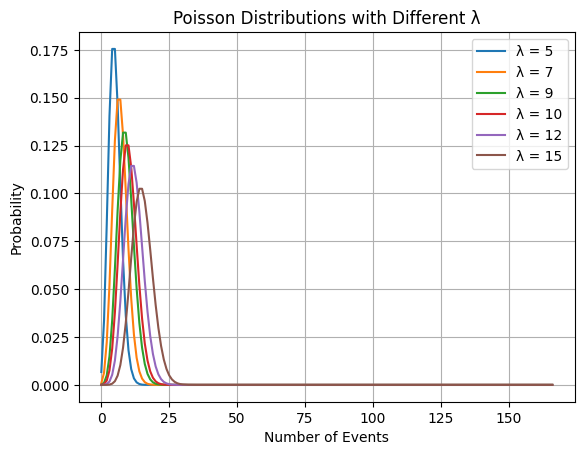

In [489]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Generate a range of x values for the plot
x = np.arange(0, n_clients / len(lambdas))

# Create a plot for each Poisson distribution and plot them as curves
for lam in lambdas:
    poisson_probabilities = poisson.pmf(x, lam)
    plt.plot(x, poisson_probabilities, label=f'λ = {lam}')

plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Poisson Distributions with Different λ')
plt.legend()
plt.grid(True)
plt.show()

In [490]:
# this class will store the info we are interested in about the simulation
class Measure:
    def __init__(self,Narr,Ndep,NAverageUser,OldTimeEvent,AverageDelay,Dropped):
        self.num_arrivals = Narr
        self.num_departures = Ndep
        self.average_utilization = NAverageUser
        self.time_last_event = OldTimeEvent
        self.average_deley_time = AverageDelay
        self.num_dropped = Dropped

# this class is the representation of a client
class Client:
    def __init__(self,Type,arrival_time):
        self.type_ = Type
        self.arrival_time = arrival_time
        
# here we store the clients in the queue
# this implements a FIFO structures (first in - first out)
class Queue:
    def __init__(self):
        self.queue = []
        
    def pop(self): # this will return and delete the first element from the queue
        return self.queue.pop(0)
    
    def append(self,client):
        if not self.is_full():
            self.queue.append(client)
            
    def is_full(self):
        return len(self.queue) >= MAX_QUEUE_CAPACITY
        
# here we store the events that are ment to appen
class PriorityQueue: # this is a list of events in the form: (time,type)
    def __init__(self):
        self.events = []
    
    def put(self,el):
        if self.events == []:
            self.events.append(el)
        else:
            for i,event in enumerate(self.events):
                if el[0] > event[0]:
                    self.events.insert(i,el)
                    break
        
    def get(self):
        return self.events.pop()

In [491]:
FES = PriorityQueue()
FES.put((0,'primo'))
FES.put((1,'secondo'))
FES.put((2,'terzo'))

print(FES.events)
print(FES.get())
print(FES.get())
print(FES.get())

[(2, 'terzo'), (1, 'secondo'), (0, 'primo')]
(0, 'primo')
(1, 'secondo')
(2, 'terzo')


In [492]:
def arrival(time, FES, queue, data):
    global users, servers
    
    # Create data for measuring simulation
    data.num_arrivals += 1
    data.average_utilization += users*(time - data.time_last_event)
    data.time_last_event = time
    
    # compute the inter-arrival time Tia for next client
    # this is not needed if I schedule all arrival from the start
    #inter_arrival = random.expovariate(1.0/ARRIVAL) # TODO
    
    # schedule an arrival at time Tcurr + Tia
    # FES.put((time + inter_arrival, "arrival"))
    
    # Create a record for the client
    client = Client(TYPE1,time)
    
    # Insert the record in the queue
    if not queue.is_full():
        users += 1
        print(f'Clients in queue: {len(queue.queue)} clients in the system: {users} available servers: {servers} full = False')
        queue.append(client)
    else:
        # print(f'Clients in queue: {len(queue.queue)} clients in the system: {users} available servers: {servers}')
        data.num_dropped += 1
    
    # If the server is idle -> make the server busy
    # this means that a client can be removed from the queue (?)
    if servers >= 1:
        client = queue.pop()
        data.average_deley_time += (time - client.arrival_time)
        # determine the service time Ts
        service_time = random.expovariate(1.0 / SERVICE)
        servers -= 1 # this is for saying that the server is busy
        
        # schedule the end of service at time Tcurr + Ts
        FES.put((time + service_time, 'departure'))

In [493]:
def departure(time, FES, queue, data):
    global users, servers
    
    data.num_departures += 1
    data.average_utilization += users*(time - data.time_last_event)
    data.time_last_event = time
    
    if len(queue.queue) > 0:
        client = queue.pop()
        #if servers < 10:
        servers += 1 # this is for saying that the server is back idel
        #print(servers)
        
        data.average_deley_time += (time - client.arrival_time)
        users -= 1
        print(f'Clients in queue: {len(queue.queue)} clients in the system: {users} available servers: {servers} departure')

        # it means that a client is waiting on the queue and that 
        if users > 0:
            service_time = random.expovariate(1.0/SERVICE)
            
            FES.put((time + service_time, 'departure'))

In [494]:
# Event Loop

# Initialization
data = Measure(0,0,0,0,0,0)
users = 0
servers = k

FES = PriorityQueue()
queue = Queue()

# Initialize cumulative arrivals for each lambda
cumulative_arrivals = [0] * len(lambdas)

# Schedule arrival events for each λ value
for i, lambd in enumerate(lambdas):
    for _ in range(n_clients // len(lambdas)):
        # Generate inter-arrival time for this type
        interarrival_time = random.expovariate(1.0 / lambd)
        
        # Schedule the arrival event with the corresponding inter-arrival time
        FES.put((cumulative_arrivals[i] + interarrival_time, 'arrival'))
        
        # Update cumulative arrivals for this type
        cumulative_arrivals[i] += interarrival_time

# FES.put((0, "arrival"))

# we have a fixed number of clients so the simulation will run untils they ends
# Event Loop
events = []
while data.num_departures < n_clients:
    if not FES.events:
        break

    (time, event_type) = FES.get()
    events.append((time,event_type))
    
    if event_type == 'arrival':
        arrival(time, FES, queue, data)
    elif event_type == 'departure':
        departure(time, FES, queue, data)

# end of the simulation
average_delay = data.average_deley_time/data.num_departures
average_no_cust = data.average_utilization/time

print(f'Total number of clients: {data.num_arrivals}\nMax queue capacity: {MAX_QUEUE_CAPACITY}')
print(f'Average time spent waiting: {average_delay:.2f}s\nAverage number of customers in the system: {average_no_cust:.2f}')
print(f'Dropped clients: {data.num_dropped} (Dropping probability: {data.num_dropped / n_clients * 100:.2f}%)')
# print(f'Number of clients in the system at the end: {n_clients - data.num_departures}')

Clients in queue: 0 clients in the system: 1 available servers: 10 full = False
Clients in queue: 0 clients in the system: 2 available servers: 9 full = False
Clients in queue: 0 clients in the system: 3 available servers: 8 full = False
Clients in queue: 0 clients in the system: 4 available servers: 7 full = False
Clients in queue: 0 clients in the system: 5 available servers: 6 full = False
Clients in queue: 0 clients in the system: 6 available servers: 5 full = False
Clients in queue: 0 clients in the system: 7 available servers: 4 full = False
Clients in queue: 0 clients in the system: 8 available servers: 3 full = False
Clients in queue: 0 clients in the system: 9 available servers: 2 full = False
Clients in queue: 0 clients in the system: 10 available servers: 1 full = False
Clients in queue: 0 clients in the system: 11 available servers: 0 full = False
Clients in queue: 0 clients in the system: 10 available servers: 1 departure
Clients in queue: 0 clients in the system: 11 avail

# Visualization

In [495]:
import pandas as pd

events_df = pd.DataFrame(events, columns=['Time','Event_Type'])
events_df.head()

,Time,Event_Type
0,6.764950,arrival
1,7.468626,arrival
2,8.961819,arrival
3,9.570014,arrival
4,10.256245,arrival


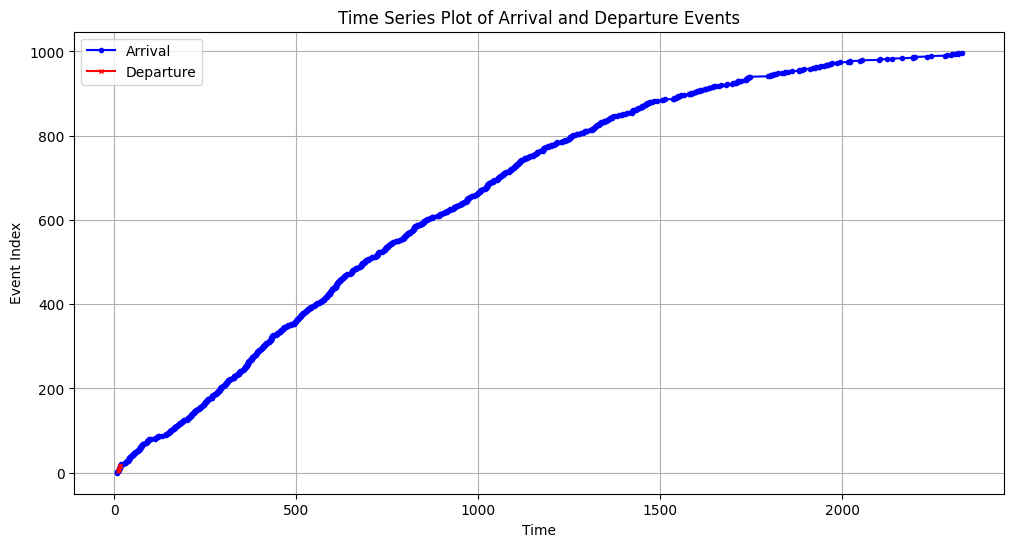

In [496]:
import matplotlib.pyplot as plt

arrival_df = events_df[events_df['Event_Type'] == 'arrival']
departure_df = events_df[events_df['Event_Type'] == 'departure']

# Create the time series plot
plt.figure(figsize=(12, 6))

# Plot arrival events in one color
plt.plot(arrival_df['Time'], arrival_df.index, label='Arrival', color='blue', marker='o', linestyle='-', markersize=3)

# Plot departure events in another color
plt.plot(departure_df['Time'], departure_df.index, label='Departure', color='red', marker='x', linestyle='-', markersize=3)

plt.xlabel('Time')
plt.ylabel('Event Index')
plt.title('Time Series Plot of Arrival and Departure Events')
plt.legend()
plt.grid(True)
plt.show()